<a href="https://colab.research.google.com/github/austinxviii/Semantic-Segmentation-of-Satellite-Imagery/blob/main/Satellite_Imagery_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **SEMANTIC SEGMENTATION OF SATELLITE IMAGERY USING U-NETS**

# Satellite Imagery Data Preparation



In [ ]:
!pip install patchify

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_root_folder = '/content/drive/MyDrive'

In [ ]:
dataset_name = "Semantic segmentation dataset"

In [ ]:
image_patch_size = 224

In [ ]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,7):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

513
513


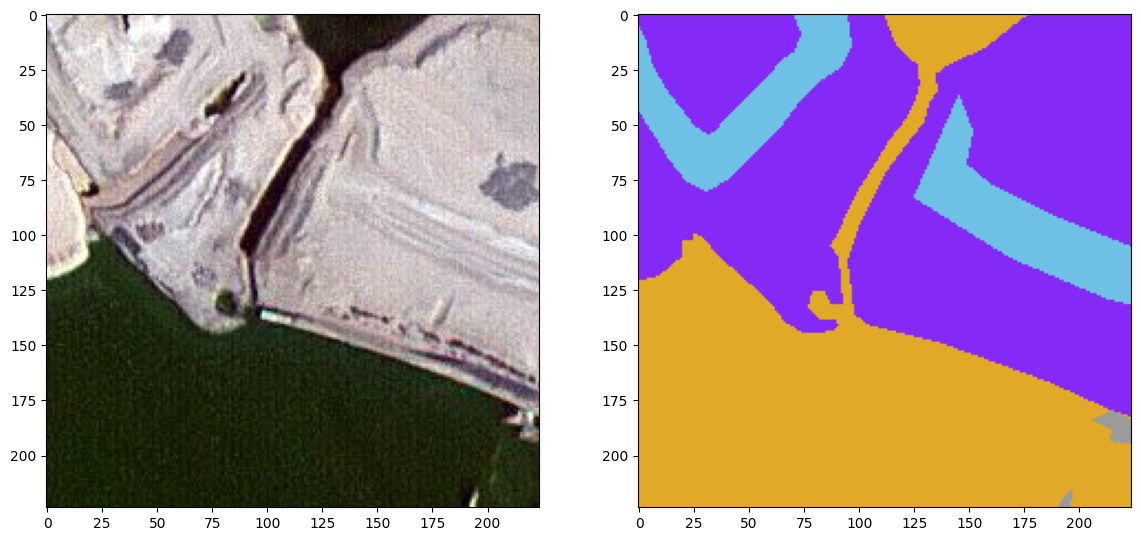

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


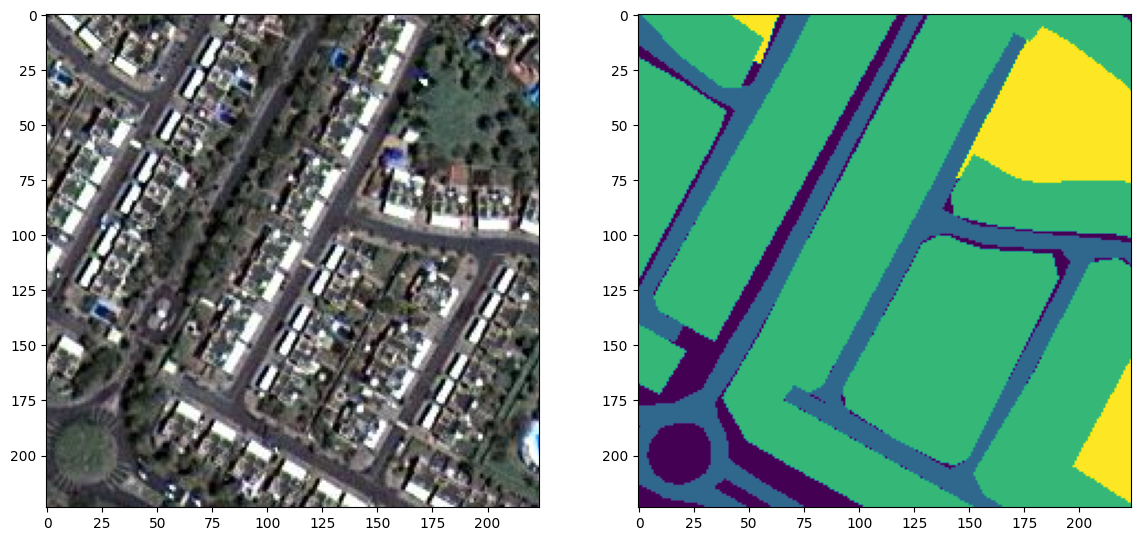

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
total_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [ ]:
master_trianing_dataset = image_dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(436, 224, 224, 3)
(77, 224, 224, 3)
(436, 224, 224, 6)
(77, 224, 224, 6)


In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

224
224
3
6


# Deep Learning with Satellite Imagery Data

In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [ ]:
from keras import backend as K

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

224
224
3
6


In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

In [ ]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
28/28 [==============================] - 31s 411ms/step - loss: 1.0164 - accuracy: 0.3721 - jaccard_coef: 0.1750 - val_loss: 1.0039 - val_accuracy: 0.4926 - val_jaccard_coef: 0.1990
Epoch 2/100
28/28 [==============================] - 4s 157ms/step - loss: 1.0024 - accuracy: 0.5587 - jaccard_coef: 0.2133 - val_loss: 0.9891 - val_accuracy: 0.6898 - val_jaccard_coef: 0.2570
Epoch 3/100
28/28 [==============================] - 5s 166ms/step - loss: 0.9825 - accuracy: 0.6436 - jaccard_coef: 0.3358 - val_loss: 0.9719 - val_accuracy: 0.6950 - val_jaccard_coef: 0.4257
Epoch 4/100
28/28 [==============================] - 4s 158ms/step - loss: 0.9754 - accuracy: 0.6513 - jaccard_coef: 0.3769 - val_loss: 0.9716 - val_accuracy: 0.6874 - val_jaccard_coef: 0.4133
Epoch 5/100
28/28 [==============================] - 4s 159ms/step - loss: 0.9721 - accuracy: 0.6591 - jaccard_coef: 0.3811 - val_loss: 0.9701 - val_accuracy: 0.6863 - val_jaccard_coef: 0.4240
Epoch 6/100
28/28 [===============

In [ ]:
history_a = model_history

In [ ]:
history_a.history

{'loss': [1.016389012336731,
  1.0024325847625732,
  0.9824665784835815,
  0.9754152894020081,
  0.972144603729248,
  0.9676815867424011,
  0.9605330228805542,
  0.9542272090911865,
  0.9528138041496277,
  0.9514943957328796,
  0.9527139067649841,
  0.95053631067276,
  0.9458655714988708,
  0.9450879693031311,
  0.9422820806503296,
  0.940717875957489,
  0.9392737150192261,
  0.9319345355033875,
  0.9303745031356812,
  0.9297135472297668,
  0.9308663010597229,
  0.9285839200019836,
  0.9299653768539429,
  0.9259646534919739,
  0.9276522994041443,
  0.922975480556488,
  0.9201458692550659,
  0.9190232157707214,
  0.9190504550933838,
  0.9179956316947937,
  0.9178279042243958,
  0.9166504740715027,
  0.9162960052490234,
  0.9309361577033997,
  0.9277399182319641,
  0.9206200242042542,
  0.9142143130302429,
  0.913787841796875,
  0.9136897921562195,
  0.9140933752059937,
  0.9112212657928467,
  0.9159049391746521,
  0.9197102785110474,
  0.9152878522872925,
  0.9105374813079834,
  0.90826

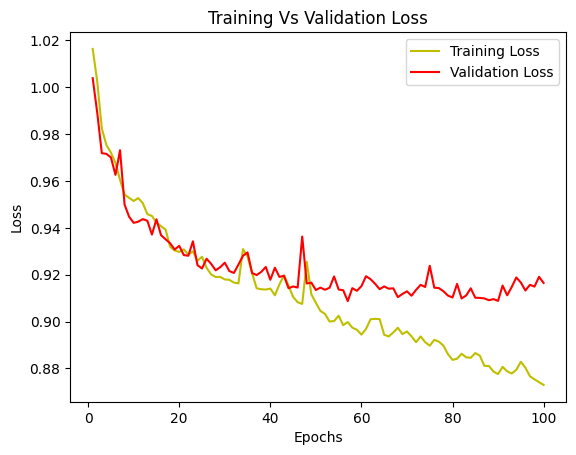

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

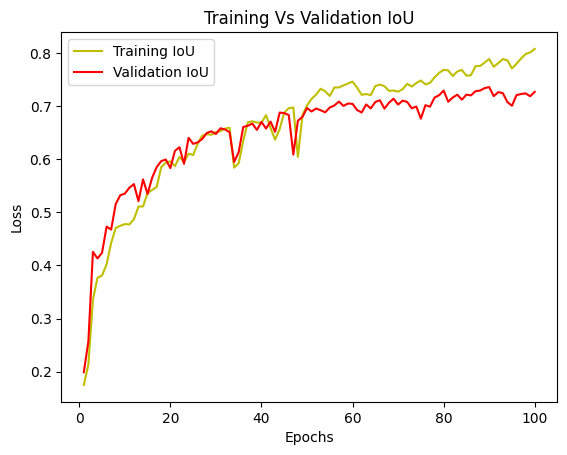

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 28}

In [ ]:
y_pred = model.predict(X_test)

3/3 [==============================] - 4s 32ms/step


In [ ]:
len(y_pred)

77

In [ ]:
y_pred

array([[[[9.26475346e-01, 6.39640093e-02, 1.62220234e-03,
          8.25899770e-05, 7.85257947e-03, 3.27188104e-06],
         [9.76797640e-01, 2.20718794e-02, 8.56088591e-05,
          1.38806683e-06, 1.04354613e-03, 5.13686871e-08],
         [9.81044114e-01, 1.78057645e-02, 4.13944435e-05,
          9.72193106e-07, 1.10772008e-03, 1.50858348e-08],
         ...,
         [9.83940482e-01, 1.40603837e-02, 8.61705048e-05,
          2.80425502e-06, 1.91012328e-03, 8.04319811e-08],
         [9.77768481e-01, 1.90910846e-02, 9.04575936e-05,
          4.10300891e-06, 3.04537057e-03, 5.14696183e-07],
         [9.27650213e-01, 5.13497032e-02, 2.88689323e-03,
          3.25329602e-04, 1.76665001e-02, 1.21362340e-04]],

        [[9.81898606e-01, 1.76812131e-02, 4.64200129e-05,
          2.98499799e-07, 3.73448565e-04, 1.98599519e-08],
         [9.95556414e-01, 4.41555353e-03, 4.94950939e-07,
          2.04027883e-09, 2.74971462e-05, 1.04072081e-11],
         [9.95982409e-01, 3.99213843e-03, 7.4705

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

77

In [ ]:
y_pred_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1]],

       [[1, 1, 2, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [1, 2, 2, ..., 1, 1, 1],
        ...,
        [1, 1, 2, ..., 2, 1, 1],
        [1, 1, 1, ..., 2, 1, 1],
        [1, 1, 1, ..., 2, 1, 1]],

       ...,

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[3, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        [2, 2, 1, ..., 3, 3, 3]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 2, 1, 1],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [ ]:
import random


In [ ]:
test_image_number = random.randint(0, len(X_test))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 26ms/step


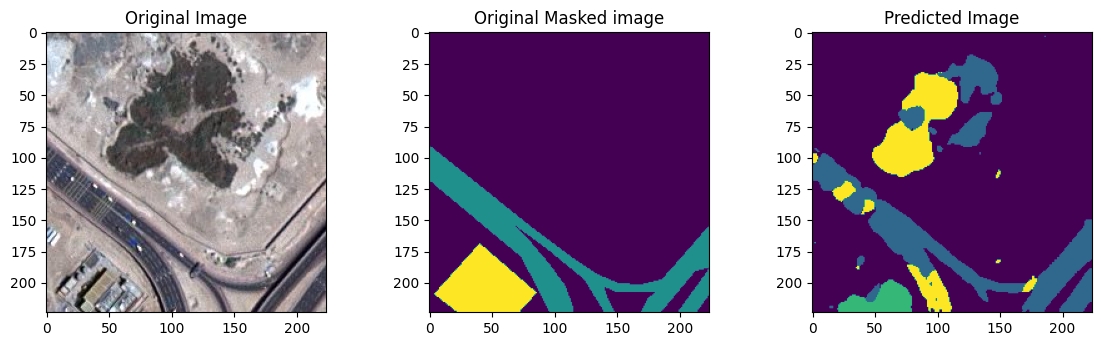

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [ ]:
model.save("satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Mar 31 16:59 .
drwxr-xr-x 1 root root 4.0K Mar 31 16:19 ..
drwxr-xr-x 4 root root 4.0K Mar 28 22:59 .config
drwx------ 5 root root 4.0K Mar 31 16:29 drive
drwxr-xr-x 1 root root 4.0K Mar 28 23:00 sample_data
-rw-r--r-- 1 root root  23M Mar 31 16:59 satellite_segmentation_full.h5
